<Time object: scale='utc' format='gps' value=0.0>

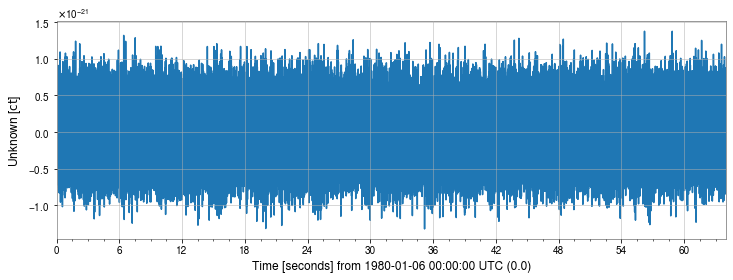

In [28]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries

data = TimeSeries.read('challenge2.gwf', 'H1:CHALLENGE2')
data.plot()
data.duration


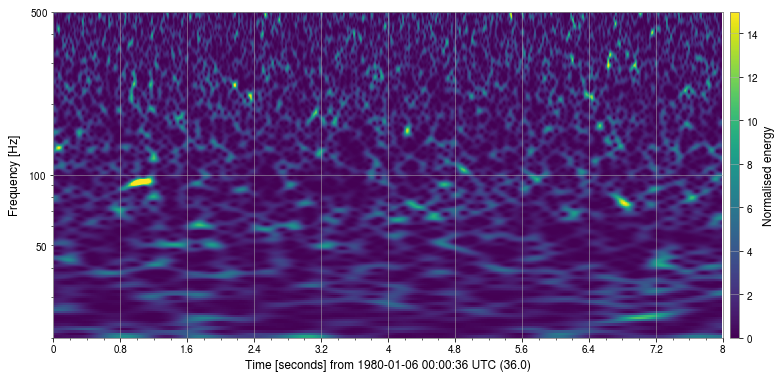

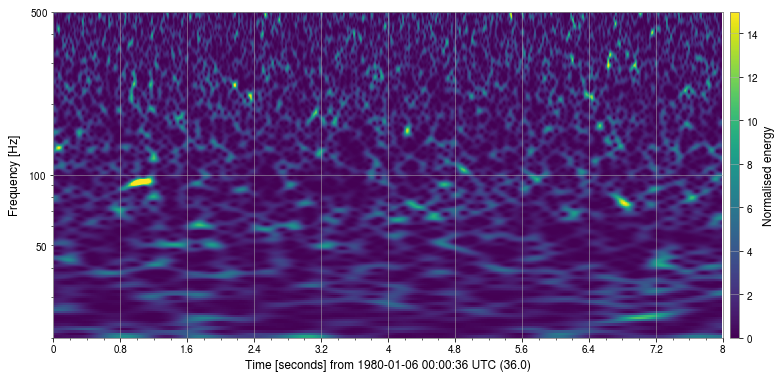

In [27]:
dq = data.q_transform(frange=(20, 500), qrange = (), outseg=(36,44))
plot = dq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
plot.colorbars[0].mappable.set_clim(0,15)
plot.refresh()
plot

In [5]:
high = data.highpass(20)
conditioned = high.to_pycbc().crop(2,2)


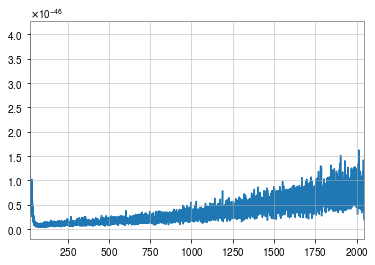

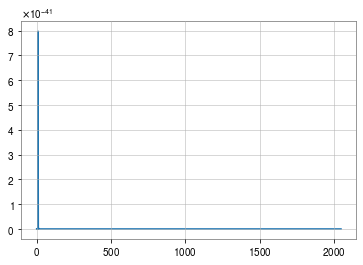

In [22]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
plt.plot(psd.sample_frequencies, psd)
plt.xlim(20, 0.5*conditioned.sample_rate)
plt.show()
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)
plt.plot(psd.sample_frequencies, psd)

plt.show()

In [8]:
from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20
)

# Resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

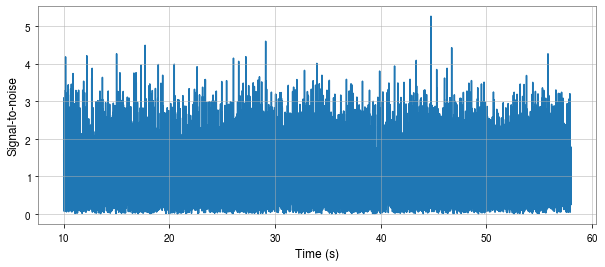

We found a signal at 44.74755859375s with SNR 5.259960701587344


In [10]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [11]:
from pycbc.vetoes import power_chisq

chisq = {}

nbins = 26
chisq = power_chisq(hp, conditioned, nbins, psd, low_frequency_cutoff=20.0)
chisq = chisq.crop(8, 4)

dof = nbins * 2 - 2
chisq /= dof


In [18]:
from pycbc.events.ranking import newsnr
print(len(chisq))
print(len(snr))
# The rho-hat term above is named "newsnr" here
nsnr = newsnr(abs(snr), chisq)

peak = abs(nsnr).argmax()
nsnrp = nsnr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with NSNR {}".format(time, 
                                                    abs(nsnrp)))


196608
196608
We found a signal at 44.74755859375s with NSNR 5.259960701587344


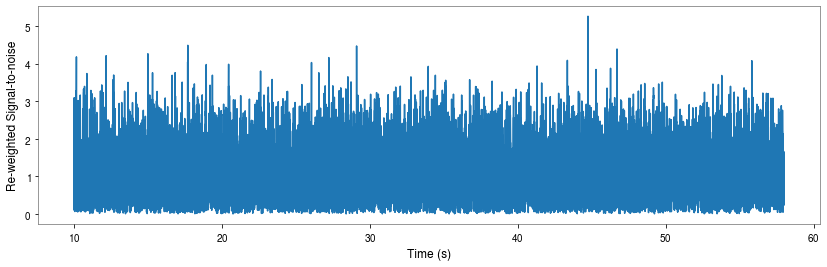

In [14]:
plt.figure(figsize=[14, 4])
plt.plot(snr.sample_times, nsnr)



plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('Re-weighted Signal-to-noise')
plt.show()